### Single Particle Systems: coding the SSH model in real and momentum space

This tutorial shows how to use QuSpin to construct single-particle Hamiltonians in real space and momentum space. To demonstrate this, we use the Su-Schrieffer-Heeger (SSH) model of free spinless fermions on a dimerised chain:
$$ H = \sum_{j=0}^{L-1} -(J+(-1)^j\delta J)\left(c_jc^\dagger_{j+1} - c^\dagger_{j}c_{j+1}\right) + \Delta\sum_{j=0}^{L-1}(-1)^jn_j,$$
where $J$ is the uniform component of the hopping, $\delta J$ -- the bond dimerisation, and $\Delta$ -- a staggered potential. 

We begin by loading the QuSpin libraries and define the model parameters

In [1]:
from quspin.operators import hamiltonian # Hamiltonians and operators
from quspin.basis import spinless_fermion_basis_1d # Hilbert space fermion basis
from quspin.tools.block_tools import block_diag_hamiltonian # block diagonalisation
import numpy as np # generic math functions
#
##### define model parameters #####
L=6 # system size
J=1.0 # uniform hopping contribution
deltaJ=0.1 # bond dimerisation
Delta=0.5 # staggered potential

Next, we construct the fermion basis using the constructor `spinless_fermion_basis_1d`. Since we are interested in a free model, it suffices to consider a single particle `Nf=1`.

In [2]:
##### construct single-particle Hamiltonian #####
# define basis
basis=spinless_fermion_basis_1d(L,Nf=1)
print(basis)

reference states: 
     0.  |1 0 0 0 0 0>
     1.  |0 1 0 0 0 0>
     2.  |0 0 1 0 0 0>
     3.  |0 0 0 1 0 0>
     4.  |0 0 0 0 1 0>
     5.  |0 0 0 0 0 1>


In defining the site-coupling list, we set a convention that the operator indices grow to the right (this is not required by QuSpin, it's merely our choice and we do it for convenience), as written out in the Hamiltonian above. Thus, the fermion hopping operator (unlike bosons) requires two different lists to reflect the sign flip in the hermitian conjugate term.

The static and dynamic lists as well as building the real-space Hamiltonian is the same as for the BHM. Last, we diagonalise the real-space Hamiltonian. 

In [3]:
# define site-coupling lists
hop_pm=[[-J-deltaJ*(-1)**i,i,(i+1)%L] for i in range(L)] # PBC
hop_mp=[[+J+deltaJ*(-1)**i,i,(i+1)%L] for i in range(L)] # PBC
stagg_pot=[[Delta*(-1)**i,i] for i in range(L)]	
# define static and dynamic lists
static=[["+-",hop_pm],["-+",hop_mp],['n',stagg_pot]]
dynamic=[]
# build real-space Hamiltonian
H=hamiltonian(static,dynamic,basis=basis,dtype=np.float64)
print("FH Hamiltonian is real space is:")
print(H.toarray())
# diagonalise real-space Hamiltonian
E,V=H.eigh()

Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
FH Hamiltonian is real space is:
[[ 0.5 -1.1  0.   0.   0.  -0.9]
 [-1.1 -0.5 -0.9  0.   0.   0. ]
 [ 0.  -0.9  0.5 -1.1  0.   0. ]
 [ 0.   0.  -1.1 -0.5 -0.9  0. ]
 [ 0.   0.   0.  -0.9  0.5 -1.1]
 [-0.9  0.   0.   0.  -1.1 -0.5]]


In momentum space, $k\in\mathrm{BZ'}=[-\pi/2,\pi/2)$, the Hamiltonian becomes block diagonal:
$$ H \!=\! \sum_{k\in\mathrm{BZ'}} (a^\dagger_k,b^\dagger_k)
\left(\begin{array}{cc}
\Delta & -(J+\delta J)\mathrm e^{-i k} - (J-\delta J)\mathrm e^{+i k} \\
-(J+\delta J)\mathrm e^{+i k} - (J-\delta J)\mathrm e^{-i k} & -\Delta
\end{array}
\right)
\left(\! \begin{array}{c}
a_k\\
b_k
\end{array}
\!\right)$$

For translation invariant single-particle models, therefore, the user might prefer to use momentum space. This can be achieved using QuSpin's `block_tools`. The idea behind it is simple: the main purpose is to create the full Hamiltonian in block-diagonal form, where the blocks correspond to pre-defined quantum numbers. In our case, we would like to use momentum or `kblock`'s. Note that the unit cell in the SSH model contains two sites, which we encode using the variable `a=2`. Thus, we can create a list of dictionaries -- `blocks`, each element of which defines a single symmetry block. If we combine all blocks, we exhaust the full Hilbert space. All other basis arguments, such as the system size, we store in the variable `basis_args`. We mention in passing that this procedure is independent of the symmetry, and can be done using all symmetries supported by QuSpin, not only translation.

In [4]:
# define basis blocks and arguments
blocks=[dict(Nf=1,kblock=i,a=2) for i in range(L//2)] # only L//2 distinct momenta
basis_args = (L,)

To create the block-diagonal Hamiltonian, we invoke the `block_diag_hamiltonian` method. It takes both required and optional arguments, and returns the transformation, which block-diagonalises the Hamiltonian (in our case the Fourier transform) and the block-diagonal Hamiltonian object. Required arguments, in order of appearance, are the `blocks`, the `static` and `dynamic` lists, the `basis` constructor, `basis_args`, and the data type. Since we expect the Hamiltonian to contain the Fourier factors $\exp(-ik)$, we know to choose a complex data type. `block_diag_hamiltonian` also accepts some optional arguments, such as the flags for disabling the automatic built-in symmetry checks.

In [5]:
# construct block-diagonal Hamiltonian
FT,Hblock = block_diag_hamiltonian(blocks,static,dynamic,spinless_fermion_basis_1d,basis_args,np.complex128,
                                   get_proj_kwargs=dict(pcon=True))
print(np.around(Hblock.toarray(),2))
# diagonalise momentum-space Hamiltonian
Eblock,Vblock=Hblock.eigh()

Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
[[ 0.50+0.j   -2.00+0.j    0.00+0.j    0.00+0.j    0.00+0.j    0.00+0.j  ]
 [-2.00+0.j   -0.50+0.j    0.00+0.j    0.00+0.j    0.00+0.j    0.00+0.j  ]
 [ 0.00+0.j    0.00+0.j    0.50+0.j   -0.65-0.78j  0.00+0.j    0.00+0.j  ]
 [ 0.00+0.j    0.00+0.j   -0.65+0.78j -0.50+0.j    0.00+0.j    0.00+0.j  ]
 [ 0.00+0.j    0.00+0.j    0.00+0.j    0.00+0.j    0.50+0.j   -0.65+0.78j]
 [ 0.00+0.j    0.00+0.j    0.00+0.j    0.00+0.j   -0.65-0.78j -0.50+0.j  ]]


We now compare the real-space and momentum-space spectra, to check if they match

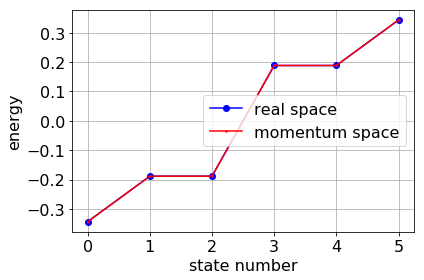

In [6]:
##### plot spectra
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(np.arange(H.Ns),E/L,marker='o',color='b',label='real space')
plt.plot(np.arange(Hblock.Ns),Eblock/L,marker='x',color='r',markersize=2,label='momentum space')
plt.xlabel('state number',fontsize=16)
plt.ylabel('energy',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.grid()
plt.tight_layout()
plt.show()